**Import the require library**

pip install os<br/>
pip install mne<br/>
pip install numpy<br/>
pip install scipy<br/>
pip install matplotlib<br/>

In [2]:
import mne
import warnings
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
from Functions import Data_path, Plot_data, Filtering, FFT, Common_average_reference, PSDA_a_trial, PSDA_all_trial

**Step 1.1: Importing pathway files**

In [3]:
# Define the base folder path where the data is located
folder_path = "D:\GitHub\SSVEP-based-EEG-signal-processing\Data" 
path_files, files, folders = Data_path.data_path(folder_path, data_format="gdf") 
path_files

['D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.27.02].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.36.29].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.44.23].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.57.52].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.17.50].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.27.18].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.45.34].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.53.10].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject4-[2012.04.08-16.06.48].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject4-[2012.04.08-16.19.25].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject4-[2012.04.08-16.2

**Step 1.2: Load data, channel locations, labels & events**<br/>
[Dataset](https://github.com/sylvchev/dataset-ssvep-led)<br/>
Label_01 ---> 13Hz stimulation (33025)<br/>
Label_02 ---> 21Hz stimulation (33026)<br/>
Label_03 ---> 17Hz stimulation (33027)<br/>
Rest ---> 33024

In [4]:
warnings.filterwarnings("ignore", message="Omitted .* annotation.*")
raw = mne.io.read_raw_gdf(path_files[0], verbose=0)   # Read the data from the GDF file into a raw MNE object
channels_name = raw.ch_names                          # Extract the channel names from the raw data
# Get the EEG data and transpose it to have channels as rows and samples as columns
data = raw.get_data().T                               
fs = raw.info['sfreq']                                # Get the sampling frequency of the EEG data
labels = raw.annotations.description                  # Define labels for each stimulation frequency
# Get the start time of each trial from the annotations
events, event_ind = mne.events_from_annotations(raw, verbose=0)  

In [5]:
print(f"data: {data}, \n channels_name: {channels_name}, \n labels: {labels}, \n events: {events}, \n event_ind: \
      {event_ind}")

data: [[ 1.17396582e-08 -4.74957048e-09 -1.26818539e-08 ...  3.03539815e-09
   1.22814473e-08  8.15642478e-09]
 [ 2.38604741e-08  5.03880715e-09 -1.56107228e-09 ...  1.22761669e-08
   2.10623854e-08  1.36445768e-08]
 [ 5.39719351e-09 -5.26715188e-09 -7.16606514e-09 ... -3.61855346e-09
   3.91582377e-09  3.01696753e-09]
 ...
 [ 1.56274671e-08  1.21936088e-08 -7.98376966e-09 ...  5.87641119e-09
   8.58811349e-09  7.09517992e-09]
 [-2.10399069e-09 -6.85034204e-10 -1.61905497e-08 ... -1.11846198e-08
  -7.72781887e-09 -8.94477811e-10]
 [-2.48514842e-09 -4.88657732e-09 -1.41685894e-08 ... -1.23060723e-08
  -4.01965243e-09  2.59246959e-09]], 
 channels_name: ['Oz', 'O1', 'O2', 'PO3', 'POz', 'PO7', 'PO8', 'PO4'], 
 labels: ['32769' '33024' '32779' '32780' '33026' '32779' '32780' '33027' '32779'
 '32780' '33025' '32779' '32780' '33026' '32779' '32780' '33025' '32779'
 '32780' '33024' '32779' '32780' '33027' '32779' '32780' '33025' '32779'
 '32780' '33026' '32779' '32780' '33027' '32779' '32780'

**Step 2.1: Split trials for a single dataset** **(** *e.g., Subject2-[2012.04.07-19.27.02].gdf* **)**

In [6]:
time_trial = 5                          # Define the duration of each trial in seconds
time_start_trial = events[:, 0]         # Extract the start time of each trial from the events
# Calculate the duration of each trial in samples based on the sampling frequency (Fs * time each trial)
duration_trial = int(fs * time_trial)   
lab = ['33025', '33026', '33027']       # Define the labels for the current iteration

for i in range(3):                      # Loop through the labels of interest
    num_trials = np.where(labels == lab[i])[0] # Find the indices of trials with the current label
    # Initialize an array to store trial data for the current label
    data_trial = np.zeros((duration_trial, len(channels_name), len(num_trials))) 
    for j, trial_index in enumerate(num_trials): # Iterate over each trial index and extract the corresponding data
        data_trial[:, :, j] = data[time_start_trial[trial_index]:time_start_trial[trial_index] + duration_trial, :]
        
    # Using exec to dynamically create variable names for each trial's data array
    exec(f'data_trial_{i + 1} = data_trial')  

print(f"data_trial_1: {data_trial_1.shape} \ndata_trial_2: {data_trial_2.shape} \ndata_trial_3: {data_trial_3.shape}")

data_trial_1: (1280, 8, 10) 
data_trial_2: (1280, 8, 10) 
data_trial_3: (1280, 8, 10)


**Step 2.2: Split trials for all datasets or stimulations**

In [7]:
data1, data2, data3 = [], [], []
lab = ['33025', '33026', '33027']       # Define the labels for the current iteration
# Calculate the duration of each trial in samples based on the sampling frequency (Fs * time each trial)
duration_trial = int(fs * time_trial)   
data_list = [data1, data2, data3]       # Initialize a list to store data lists

for i in range(len(path_files)):
    raw = mne.io.read_raw_gdf(path_files[i], verbose=0) # Read the data from the GDF file into a raw MNE object
    fs = raw.info['sfreq']                              # Get the sampling frequency of the EEG data
    # Get the EEG data and transpose it to have channels as rows and samples as columns
    data = raw.get_data().T
    labels = raw.annotations.description                # Define labels for each stimulation frequency
    events, _ = mne.events_from_annotations(raw, verbose=0) # Get the start time of each trial from the annotations
    time_start_trial = events[:, 0]                     # Extract the start time of each trial from the events 
    
    for j in range(3):                                  # Loop through the labels of interest
        num_trials = np.where(labels == lab[j])[0]      # Find the indices of trials with the current label
        # Initialize an array to store trial data for the current label
        data_trial = np.zeros((duration_trial, len(channels_name), len(num_trials))) 

        for ind, trial_index in enumerate(num_trials):  # Iterate over each trial index and extract the corresponding data
            data_trial[:, :, ind] = data[time_start_trial[trial_index]:time_start_trial[trial_index] + duration_trial, :]
        
        # Append data_trial to the corresponding list based on the value of j
        data_list[j].append(data_trial)
        
# Concatenate the lists of data arrays along the third axis
data1 = np.concatenate(data1, axis=2)
data2 = np.concatenate(data2, axis=2)
data3 = np.concatenate(data3, axis=2)

print(f"data1.shape: {data1.shape} \ndata2.shape: {data2.shape} \ndata3.shape: {data3.shape}")

data1.shape: (1280, 8, 160) 
data2.shape: (1280, 8, 160) 
data3.shape: (1280, 8, 160)


**Step 2.3: Plot data (** *Plot a trial for one of the stimulation frequencies* **)**<br/>

*Input parameters:*
 - `data:` data1[:, :, max(0, trial - 1)]: EEG data for the specified trial (indedatang starts from 0)
 - `fs:` Sampling frequency of the EEG data
 - `channels:` Names of the EEG channels
 - `first_point:` Index of the first data point to plot (optional, defaults to 0)
 - `last_point: `Index of the last data point to plot (optional, defaults to 3000)
 - `val_ylim:` Madatamum absolute y-adatas limit for the plot (optional, defaults to 2.7)
 - `size_fig:` Size of the figure (optional, defaults to (5, 5))
 - `title:` Title of the plot (optional, defaults to 'Raw data')
 - `display_figure:` Whether to display the figure ('on' or 'off') (optional, defaults to 'on')

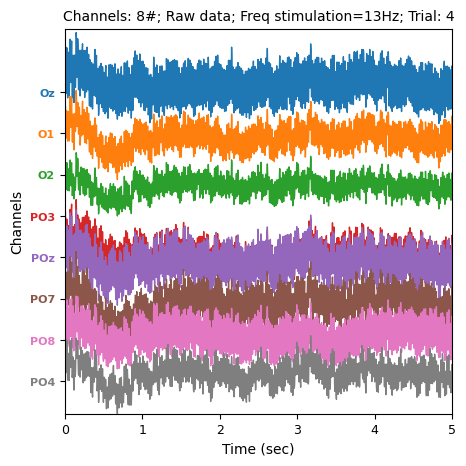

In [8]:
trial = 4          # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
freq_stim = 13     # Define stimulation frequency

# Plot EEG data using the Plot_data.plot_data function
title = f'Raw data; Freq stimulation={13}Hz; Trial: {max(1, trial)}'
Plot_data.plot_data(data1[:, :, max(0, trial - 1)], fs, channels_name, first_point=0, last_point=1280, val_ylim=2.7, 
                    size_fig=(5,5), title=title, display_figure="on")  

**Step 3.1: Filtering (** *Filter a trial for one of the stimulation frequencies* **)**<br/>

*Input parameters:*
 - `data:` EEG data to be filtered
 - `f_low:` Lower cutoff frequency of the bandpass filter
 - `f_high:` Upper cutoff frequency of the bandpass filter
 - `order:` Filter order
 - `fs:` Sampling frequency of the EEG data (optional, if not provided, it is assumed to be fs)
 - `type_filter:` Type of filter ('low', 'high', 'bandpass', or 'bandstop') (optional, defaults to 'bandpass')
 - `filter_active:` Filter data using a specific type of filter ('low', 'high', 'bandpass', or 'bandstop') (optional, defaults to 'on')
 - `notch_freq:` Frequency to be removed from signal (Hz)
 - `quality_factor:` Quality factor for notch filter
 - `filter_active:` Whether to activate filtering ("on" or "off")
  - `notch_filter:` Whether to apply a notch filter ("on" or "off")

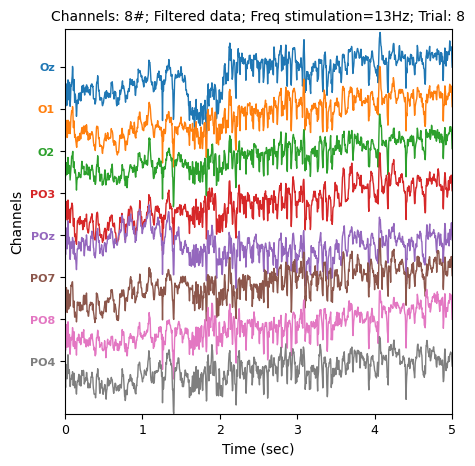

In [9]:
trial = 8            # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
order = 3            # Define filter order
f_low = 0.05         # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = 100         # Define upper cutoff frequency for the bandpass filter (Hz)
notch_freq = 50      # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20  # Define quality factor for the notch filter

# Apply bandpass filtering to the EEG data using the Filtering.filtering function
title = f'Filtered data; Freq stimulation=13Hz; Trial: {max(1, trial)}'
filtered_data = Filtering.filtering(data1, f_low, f_high, order, fs, notch_freq, quality_factor, filter_active="on",
                                    notch_filter="on", type_filter='bandpass')
Plot_data.plot_data(filtered_data[:, :, max(0, trial - 1)], fs, channels_name, first_point=0, last_point=1280, 
                    val_ylim=2.7, size_fig=(5,5), title=title, display_figure="on")

**Step 3.2: Fourier transform** **(** *FFT a channel for one of the stimulation frequencies* **)**

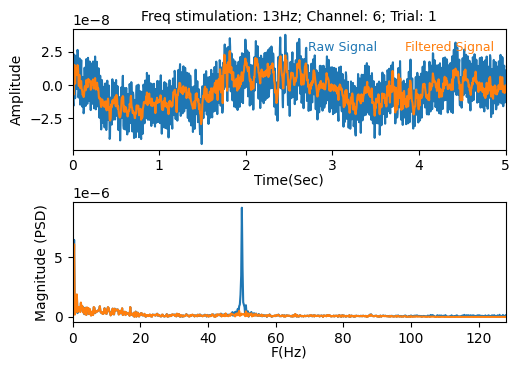

In [10]:
trial = 0              # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
channel = 6            # Define channel (trial 1 in Python index starts from 0, so channel 1 means index 0)

title = f"Freq stimulation: {13}Hz; Channel: {max(1, channel)}; Trial: {max(1, trial)}"
FFT.fft_analysis(data1, filtered_data, fs, channel, trial, title, size_fig=[5, 3.5])

**Step 3.3: CAR filter** **(** *CAR a trial for one of the stimulation frequencies* **)**<br/>

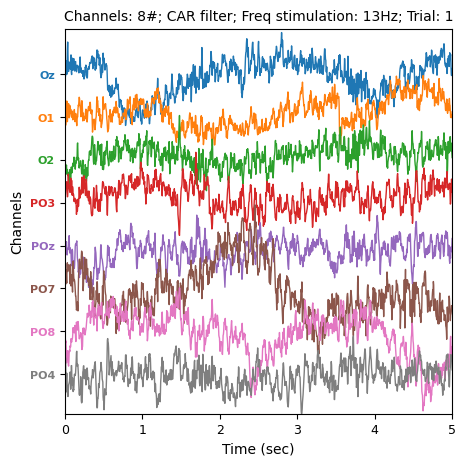

In [11]:
trial = 0              # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)

# Apply common average reference (CAR) to the EEG data using the Common_average_reference.car function
title = f"CAR filter; Freq stimulation: {13}Hz; Trial: {max(1, trial)}"
data_car = Common_average_reference.car(filtered_data) 
Plot_data.plot_data(data_car[:, :, max(0, trial - 1)], fs, channels_name, first_point=0, last_point=1280, val_ylim=2.7,
                    size_fig=(5,5), title=title, display_figure="on")

**Step 4.1: Power Spectral Density Analysis (PSDA)** **(** *PSDA a channel & a trial for one of the stimulation frequencies* **)**<br/>
[Article 1](https://www.researchgate.net/profile/Javier-Castillo-27/publication/263618753_Feature_Extraction_Techniques_Based_on_Power_Spectrum_for_a_SSVEP-BCI/links/5527b5a60cf29b22c9b937bd/Feature-Extraction-Techniques-Based-on-Power-Spectrum-for-a-SSVEP-BCI.pdf);  [Article 2](https://www.researchgate.net/publication/301341524_EEG_Signal_Analysis_Methods_Based_on_Steady_State_Visual_Evoked_Potential_Stimuli_for_the_Development_of_Brain_Computer_Interfaces_A_Review_Address_for_Correspondence)<br/>
$S_k = 10 \log_{10} \left( \frac{nP(f_k)}{\sum_{m=1}^{n/2} \left[P(f + mf_{res}) + P(f - mf_{res})\right]} \right)$<br/>
where `n` is the number of points near at the frequency stimulus, `P(fk)` is the power density of the stimulus frequencies and `fres `is the resolution frequency, which depends on the number of samples used in the Fourier transform. `P(fk + mfres)` and `P(fk −mfres) `are power densities around the target frequency.

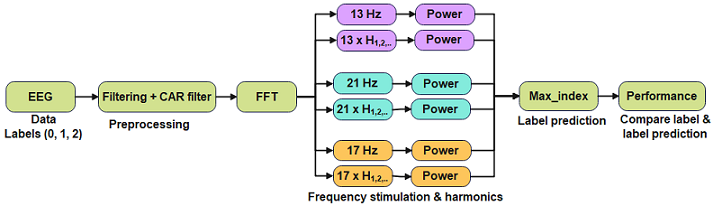

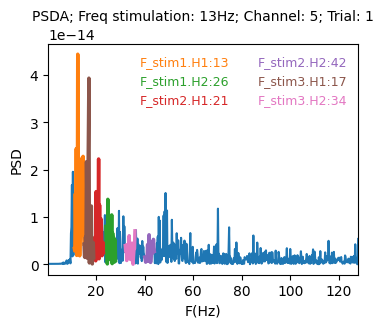

In [18]:
# ------------------------ Step 1: Filtering for one of the stimulation frequencies -------------------------------
trial = 8                # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
order = 3                # Define filter order
f_low = 0.05             # Define lower cutoff frequency for the bandpass filter (Hz)
f_stim = [13, 21, 17]    # Frequencies stimulation
f_high = min(f_stim) - 1 # Define upper cutoff frequency for the bandpass filter (Hz)
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
filtered_data = Filtering.filtering(data1, f_low, f_high, order, fs, notch_freq, quality_factor, filter_active="on",
                                    notch_filter="on", type_filter='high')
# ---------------------------- Step 2: CAR for one of the stimulation frequencies----------------------------------
data_car = Common_average_reference.car(filtered_data)
# -------------------------- Step 3: PSDA for one of the stimulation frequencies-----------------------------------
trial = 0              # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
channel = 5            # Define channel (trial 1 in Python index starts from 0, so channel 1 means index 0)
num_harmonic = 2       # Number of harmonic for each frequency stimulation
num_sample_neigh = 20  # Number of samples neighborhood for each frequency stimulation

title = f"PSDA; Freq stimulation: {13}Hz; Channel: {max(1, channel)}; Trial: {max(1, trial)}"
max_freq, label = PSDA_a_trial.psda_a_trial(data_car[:, max(0, channel - 1), max(0, trial - 1)], fs, num_sample_neigh, 
                                            f_stim, num_harmonic, title, fig_size=[4, 3])

**Step 4.2: Power Spectral Density Analysis (PSDA) for all datasets or stimulations**<br/>

In [14]:
# ------------------------------------ Step 1: Combine all of datasets --------------------------------------------
data_total = np.concatenate((data1, data2, data3), axis=2)
labels = np.concatenate((np.full(data1.shape[-1], 0), np.full(data1.shape[-1], 1), np.full(data1.shape[-1], 2)))
# ----------------------------------- Step 2: Filtering for all of datasets ---------------------------------------
trial = 8                # Trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
order = 3                # Define filter order
f_low = 0.05             # Define lower cutoff frequency for the bandpass filter (Hz)
f_stim = [13, 21, 17]    # Frequencies stimulation
f_high = 100             # Define upper cutoff frequency for the bandpass filter (Hz)
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
filtered_data = Filtering.filtering(data_total, f_low, f_high, order, fs, notch_freq, quality_factor, filter_active=\
                                    "off", notch_filter="on", type_filter='bandpass')
# -------------------------------------- Step 3: CAR for all of datasets ------------------------------------------
data_car = Common_average_reference.car(filtered_data) 
# ------------------------------------- Step 4: PSDA for all of datasets ------------------------------------------
trial = 0                 # Trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
num_channel = [0, 1, 2]   # Number of Channel          
num_harmonic = 2          # Number of harmonic for each frequency stimulation
num_sample_neigh = 30     # Number of samples neighborhood for each frequency stimulation

predict_label = PSDA_all_trial.psda_all_trial(data_car[:, num_channel], f_stim, num_sample_neigh, fs,
                                              num_harmonic)
print(f"Accuracy: {np.sum(labels == predict_label) / len(predict_label) * 100:.2f}")

Accuracy: 94.79


**Step 3: CCA Method**

In [ ]:
x = data_trial_1[:,:,1]           # (number samples, number channel, number trials)
num_harmonic = 2                  # Number of harmonic for each frequency stimulation
num_channel = [0, 1]              # Number of Channel
f_stim = [13, 21, 17]             # Freqquencies stimuation
num_sample_neigh = 20             # Number of samples neighborhood for each frequency stimulation
num_samples_trial = int(fs * duration_trial)            
time = np.linspace(0, duration_trial, num_samples_trial)  # Time vector

f_low, f_high, order = 5, 50, 3    # Define filter parameters
data = Filtering.filtering(x, f_low, f_high, order, fs, type_filter='bandstop') # Apply bandstop filtering to the EEG data 

f_high, order = min(f_stim) - 1, 3    # Define filter parameters
data = Filtering.filtering(x, f_low, f_high, order, fs, type_filter='high') # Apply high filtering to the EEG data 

In [55]:
from scipy.linalg import canoncorr
f_ref = np.zeros(len(f_stim))
for i in range(len(f_stim)):  # First loop for frequencies stimulation
    data_ref = np.zeros((len(time), 2 * num_harmonic))
    for j in range(num_harmonic):  # Second loop creates a reference signal for each frequency stimulation
        signal_ref = np.zeros((len(time), 2))
        signal_ref[:, 0] = np.sin(2 * np.pi * (j + 1) * f_stim[i] * time)
        signal_ref[:, 1] = np.cos(2 * np.pi * (j + 1) * f_stim[i] * time)
        data_ref[:, j * 2:(j + 1) * 2] = signal_ref
    _, _, a = canoncorr(data[:, num_channel], data_ref)
    f_ref[i] = np.max(a)
label_predic = np.argmax(f_ref)

ImportError: cannot import name 'canoncorr' from 'scipy.linalg' (c:\Users\RezaS\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\linalg\__init__.py)